In [1]:
%%capture
%cd drive/MyDrive/genrecog/
%pip install speechbrain

In [2]:
from genrecog.preprocess.preprocessor import Preprocessor

train_preprcessor = Preprocessor('dataset/npz_files/train.npz')
test_preprcessor = Preprocessor('dataset/npz_files/test.npz')

In [3]:
X,y = train_preprcessor.as_shuffled_torch()
X_test, y_test = test_preprcessor.as_shuffled_torch()


In [4]:
from genrecog.preprocess.feature import Feature

feature_maker = Feature()
X_sample = feature_maker.torch_fbank_features(X[:100])

In [5]:
X_sample = X_sample.transpose(1,2)
# X_sample_1 = X_sample[:,:,:100]

In [6]:
# import torch

# class CNN(nn.Module):
#   def __init__(self) -> None:
#       super().__init__()

In [7]:
import torch

torch.manual_seed(0)

filter_num = 128
filter_size = 4

model = torch.nn.Sequential(
    torch.nn.Conv1d(in_channels=40, 
                    out_channels=filter_num, 
                    kernel_size=filter_size, 
                    padding=filter_size//2
                    ),
    # torch.nn.BatchNorm1d(filter_num),
    torch.nn.ReLU(),
    # torch.nn.Dropout(),
    torch.nn.MaxPool1d(kernel_size=2),
    torch.nn.Conv1d(in_channels=128, 
                    out_channels=filter_num, 
                    kernel_size=filter_size, 
                    padding=filter_size//2
                    ),
    # torch.nn.BatchNorm1d(filter_num),
    torch.nn.ReLU(),
    # torch.nn.Dropout(),
    torch.nn.MaxPool1d(kernel_size=2),
    torch.nn.Conv1d(in_channels=128, 
                    out_channels=filter_num, 
                    kernel_size=filter_size, 
                    padding=filter_size//2
                    ),
    # torch.nn.BatchNorm1d(filter_num),
    torch.nn.ReLU(),
    # torch.nn.Dropout(),
    torch.nn.MaxPool1d(kernel_size=2),
    torch.nn.Conv1d(in_channels=128, 
                    out_channels=filter_num, 
                    kernel_size=filter_size, 
                    padding=filter_size//2
                    ),
    # torch.nn.BatchNorm1d(filter_num),
    torch.nn.ReLU(),
    # torch.nn.Dropout(),
    # torch.nn.MaxPool1d(kernel_size=2),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=11392  , out_features=1100),
    torch.nn.Linear(in_features=1100 , out_features=10)
)

loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [8]:
y_pred = model(X_sample)  # Check model architecture by trying to feed inputs through it.
assert y_pred.shape == (100, 10), "Expected a batch of 100 samples to produce output of shape (100, 10)"

In [9]:
def train(model, dataloader,num_epochs=10):
  for i in range(0, num_epochs):
    model.train()
    for X_trn, y_trn in dataloader:
      model.zero_grad()
      X_trn = feature_maker.torch_fbank_features(X_trn).transpose(1,2)
      y_hat = model(X_trn)
      l = loss(y_hat, y_trn)
      l.backward()
      optimizer.step()
      print("Epoch %2d final minibatch had loss %.4f" % (i, l.item()))
    test(model, X_test, y_test)


In [10]:
def test(model, X_test, y_test):
  model.eval()
  with torch.no_grad():
    X_tst = feature_maker.torch_fbank_features(X_test).transpose(1,2)
    y_pred = torch.softmax(model(X_tst), dim=1)
    l = loss(y_pred, y_test)
    print(l.item())
    # print(torch.argmax(pred, dim=1))
    # print(y_test)
  return y_pred
        # correct = 0
        # total = 0
        # for images, labels in dataloader:
        #     test_output, last_layer = model(images)
        #     pred_y = torch.max(test_output, 1)[1].data.squeeze()
        #     accuracy = (pred_y == labels).sum().item() / float(labels.size(0))


In [24]:
from torch.utils.data import TensorDataset, DataLoader

num_epoch = 10
td = TensorDataset(X,y)
dl = DataLoader(td, shuffle=True, batch_size=600)
# model.cuda()
train(model, dl, 20)

  # model.eval()
  # y_hat_test = model(feature_maker.torch_fbank_features(X_test).transpose(1,2))
  # l_t = loss(y_hat_test, y_test)
  # print("Epoch %2d test loss %.4f" % (i, l_t.item()))

Epoch  0 final minibatch had loss 0.6840
Epoch  0 final minibatch had loss 0.6007
Epoch  0 final minibatch had loss 0.6278
Epoch  0 final minibatch had loss 0.6334
Epoch  0 final minibatch had loss 0.6700
Epoch  0 final minibatch had loss 0.5785
1.9925761222839355
Epoch  1 final minibatch had loss 0.6814
Epoch  1 final minibatch had loss 0.5977
Epoch  1 final minibatch had loss 0.6837
Epoch  1 final minibatch had loss 0.7369
Epoch  1 final minibatch had loss 0.6566
Epoch  1 final minibatch had loss 0.7375
2.0516483783721924
Epoch  2 final minibatch had loss 0.7625
Epoch  2 final minibatch had loss 0.7250
Epoch  2 final minibatch had loss 0.6273
Epoch  2 final minibatch had loss 0.8749
Epoch  2 final minibatch had loss 0.6552
Epoch  2 final minibatch had loss 0.7294
2.0275280475616455
Epoch  3 final minibatch had loss 0.6538
Epoch  3 final minibatch had loss 0.6668
Epoch  3 final minibatch had loss 0.6193
Epoch  3 final minibatch had loss 0.7034
Epoch  3 final minibatch had loss 0.5968


In [21]:
# X_tst = feature_maker.torch_fbank_features(X_test).transpose(1,2)
# print(X_trn.shape)
# X_tst.shape
print(X_test.shape)
pred = test(model, X_test, y_test)
# model.train()
# pred = model(feature_maker.torch_fbank_features(X_test).transpose(1,2))
pred

torch.Size([400, 154350])
2.031846284866333


tensor([[5.7441e-03, 9.6060e-06, 2.9159e-09,  ..., 5.3226e-04, 1.9218e-01,
         1.5155e-04],
        [2.5153e-01, 1.2031e-03, 1.2450e-02,  ..., 7.1467e-02, 2.2391e-02,
         5.4684e-01],
        [9.7110e-02, 2.9575e-02, 9.3063e-06,  ..., 4.9934e-03, 7.3459e-01,
         5.8409e-02],
        ...,
        [6.0145e-04, 8.8781e-01, 1.9558e-07,  ..., 2.6423e-05, 8.6264e-05,
         9.5766e-04],
        [6.7060e-04, 3.5318e-01, 1.5783e-07,  ..., 8.1950e-02, 7.2402e-03,
         1.2751e-02],
        [6.3699e-05, 3.0992e-01, 1.8859e-06,  ..., 3.5613e-05, 2.2585e-04,
         2.6818e-03]])

In [13]:
# model.eval()
# pred = torch.softmax(model(X_tst), dim=1)
# print(torch.argmax(pred, dim=1))
# print(y_test)

In [22]:
from sklearn.metrics import confusion_matrix
y_pred = torch.argmax(pred, dim=1)
confusion_matrix(y_test, y_pred)/0.4


array([[52.5,  0. ,  0. ,  0. ,  5. ,  2.5,  0. ,  7.5, 17.5, 15. ],
       [15. , 47.5,  7.5,  0. ,  2.5,  2.5, 10. ,  0. ,  7.5,  7.5],
       [ 0. ,  2.5, 47.5,  0. ,  0. ,  5. ,  7.5, 22.5,  0. , 15. ],
       [ 0. ,  2.5,  0. , 62.5,  0. , 30. ,  5. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , 77.5,  0. , 12.5,  2.5,  7.5,  0. ],
       [ 0. ,  0. ,  5. ,  0. ,  0. , 67.5,  5. , 20. ,  0. ,  2.5],
       [ 2.5, 17.5, 12.5,  0. ,  0. , 15. , 42.5, 10. ,  0. ,  0. ],
       [17.5,  7.5,  5. ,  0. ,  0. , 15. ,  0. , 25. , 27.5,  2.5],
       [10. ,  0. ,  0. , 15. ,  0. ,  5. ,  0. , 35. , 32.5,  2.5],
       [ 7.5,  0. , 12.5,  0. ,  2.5,  2.5,  2.5, 27.5,  2.5, 42.5]])

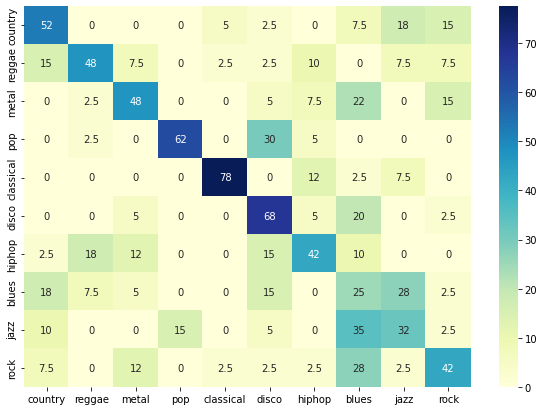

In [23]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(y_test, y_pred)/0.4
genres = ['country', 'reggae', 'metal', 'pop', 'classical', 'disco', 'hiphop', 'blues', 'jazz', 'rock']
df_cm = pd.DataFrame(array, index = genres, columns = genres)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu")


In [16]:
loss(pred, y_test)

tensor(2.1006)

In [17]:
class LSTMTagger(torch.nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = torch.nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = torch.nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = torch.F.log_softmax(tag_space, dim=1)
        return tag_scores

In [18]:
import torch

torch.manual_seed(0)

filter_num = 100
filter_size = 10

# model_2 = torch.nn.Sequential(
#     torch.nn.LSTM(702, 40, 100, batch_first=True),
    # torch.nn.Conv1d(in_channels=40, 
    #                 out_channels=filter_num, 
    #                 kernel_size=filter_size, 
    #                 padding=filter_size//2
    #                 ),
    # torch.nn.BatchNorm1d(filter_num),
    # torch.nn.ReLU(),
    # torch.nn.Dropout(),
    # torch.nn.MaxPool1d(kernel_size=filter_size),
    # torch.nn.Conv1d(in_channels=100, 
    #                 out_channels=filter_num, 
    #                 kernel_size=filter_size, 
    #                 padding=filter_size//2
    #                 ),
    # torch.nn.BatchNorm1d(filter_num),
    # torch.nn.ReLU(),
    # torch.nn.Dropout(),
    # torch.nn.MaxPool1d(kernel_size=filter_size),
    # torch.nn.Flatten(),
    # torch.nn.Linear(in_features=700 , out_features=10)
# )

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))

loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())

NameError: ignored

In [ ]:
print(X_sample.shape)
y_pred = model_2(X_sample)  # Check model architecture by trying to feed inputs through it.
assert y_pred.shape == (100, 10), "Expected a batch of 100 samples to produce output of shape (100, 10)"

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

num_epoch = 10
td = TensorDataset(X,y)
dl = DataLoader(td, shuffle=True, batch_size=400)

for i in range(0, num_epoch):
  for X_trn, y_trn in dl:
    # print(X.shape)
    model_2.zero_grad()
    X_trn = feature_maker.torch_fbank_features(X_trn).transpose(1,2)
    y_hat = model_2(X_trn)
    l = loss(y_hat, y_trn)
    l.backward()
    optimizer.step()
    print("Epoch %2d final minibatch had loss %.4f" % (i, l.item()))
  # y_hat_test = model_2(feature_maker.torch_fbank_features(X_test).transpose(1,2))
  # l_t = loss(y_hat_test, y_test)
  # print("Epoch %2d test loss %.4f" % (i, l_t.item()))